# Import relevant libraries and packages. 

In [13]:
import nidaqmx
from nidaqmx import Task
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import serial
from serial.tools import list_ports
import time


# Define Functions 

Define the functions that will be used to control the syringe pump and acquire data

In [2]:
def get_device_port():
    
    """
    'get_device_port'  obtains the pump device port which is usually the highest device port

    Returns: 
        Device Port
    """
    
    #Iterate through list in reverse to get highest device COM port
    for comport in reversed(list_ports.comports()):
        device_name = comport.device
        with serial.Serial(device_name, timeout=3) as ser: 
            ser.write(b'/1?\r')
            reading=ser.read_until(b'\r')
            if(reading):
                return device_name
    raise IOError("Syringe not found")


In [3]:
def initialize_and_fill():
    
    ''''
    This function initializes the pump and fills the syringe. 
    It then releases 1000 steps into the output syringe to remove backlash. 
    The pump must be empty before this is called. 
    '''
    
    print('filling syringe')
    
    device_port = get_device_port()
    with serial.Serial(device_port, timeout=5) as ser:
        ser.write(b'/1ZN1R\r')
        time.sleep(5)
        ser.write(b'/1IA12000R\r')
        time.sleep(5)
        ser.write(b'/1OD1000R\r')
        
        # the length of sleep may be shortened
        # but must be sufficiently long between commands sent to the syringe pump
        time.sleep(5)
        

In [4]:
def return_and_close():
    
    '''
    This function returns the untitrated amount back to the input syringe
    '''
    
    print('emptying syringe')
    
    device_port = get_device_port()
    with serial.Serial(device_port, timeout=5) as ser:
        ser.write(b'/1IA0R\r')
    
    

In [5]:
def add_titrant(num_steps):
    
    '''
    This function adds some amount of titrant to the syringe. 
    
    The function takes the argument:
        num_steps = number of steps in the pump motor which detemines amount of titrant added
    '''
    
    print('adding titrant')
    
    device_port = get_device_port()
    to_write = '/1OD' + str(num_steps) + 'R\r'
    with serial.Serial(device_port, timeout=5) as ser:
        ser.write(to_write.encode('utf-8'))
        
    # the length of sleep may be shortened
    # but must be sufficiently long between commands sent to the syringe pump
    time.sleep(5)
    
    

In [6]:
def get_potential_measurement(samp_rate, samp_num):
    
    '''
    'get_voltage_measurement' is identical to E1. Each acquisition samples the potential some number of times at some sampling rate.
    
    The function takes two arguments:
        samp_rate = rate at which data is sampled per second 
        samp_num = total number of samples in a single data aquisition
        
    and returns:
       v_m = a list of all potentials sampled in the data acquisition
        
    '''
    
    
    # get a list of devices
    all_devices = list(nidaqmx.system.System.local().devices)
    
    # throw error if no devices are found or if multiple devices are found
    if (len(all_devices) == 0):
        raise IOError("No DAQ device found")
    if (not (len(all_devices) == 1)):
        warnings.warn("More than one DAQ device found. Using the first device. \
            Manually change dev_name to use other device")
        
    # otherwise use the first device that's found
    dev_name = all_devices[0].name
    
    # collect data, assign to v_m
    with Task() as task:
        
        # add input channel and set E range ( For CHEM174/274 potentiostat E range is always [-10,10] )
        task.ai_channels.add_ai_voltage_chan(dev_name + "/ai0", max_val=10, min_val=-10)
        
        '''
        # set the input voltage range to [-1,1]
        task.ai_channels.all.ai_min = -1
        task.ai_channels.all.ai_max = 1
        '''
        
        # set sampling rate and number of samples in acquisition 
        task.timing.cfg_samp_clk_timing(samp_rate, samps_per_chan=samp_num)
        
        # collect data from daq
        v_m = task.read(samp_num, timeout=nidaqmx.constants.WAIT_INFINITELY)
        
    return v_m

# Section 1: Potential Measurement of Concentrations Cells

In this section you will be making potential measurements of the 7 ferrocyanide/ferrocyanide solutions (solutions 1-7) relative to the 0.5M ferrocyanide/0.5M ferricyanide solution (solution 4). The script is similar to E1 where each potential acquisition is sequentially added to some plot. 

Code Block 1 creates empty arrays to store the mean and standard deviation of each potential measurement. 
Code Block 2 defines sampling parameters, measures the potential and plots each potential measured. 

Running Code Block 2 multiple times continuously adds data points to the plot while running Code Block 1 resets the stored data. **Make sure to change 'acq_name' in Code Block 2 each time you switch solutions.**   

In [8]:
'''Code Block 1'''

# stores the mean and standard deviation of each potential acquisition 
mean_meas = []
std_meas = []

# x axis label for each acquisition 
sol_num = [] 

In [14]:
'''Code Block 2'''

# define x axis tick label for acquisition (can be solution concentration or anything) and append to 'sol_conc' array
acq_name = 'solution 1'
sol_num.append(acq_name)

# define sampling rate and sampling number 
samp_rate = 1000
samp_num = 1500

# collect data
measured_potential = get_potential_measurement(samp_rate, samp_num)

# append mean and standard deviation of potential to 'mean_meas' and 'std_meas' which store data from all acquisitions
mean_meas.append(np.mean(measured_potential))
std_meas.append(np.std(measured_potential))

# set up subplot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

# subplot 1 
ax1.scatter(np.arange(len(measured_potential)), measured_potential)
ax1.set_title('Potential vs Sampling Number Previous Acquisition', fontsize = 16)
ax1.set_xlabel('Sampling Number', fontsize = 16)
ax1.set_ylabel('Potential (V)', fontsize = 16)

# subplot 2 
ax2.errorbar(x = np.arange(len(mean_meas)), y = mean_meas , yerr = std_meas,  fmt='bo')
ax2.set_title('Potential vs Sol 4', fontsize = 16)
ax2.set_ylabel('Potential (V)', fontsize = 16)
ax2.set_xticklabels(np.arange(0, len(sol_num))) 
ax2.set_xticklabels(sol_num) 

# Save figure in the current directory. Note this will overwrite existing images with the same filename 
plt.savefig('Ferrocyanide solutions vs sol 4.png', dpi = 300, bbox_inches='tight')

# save data
ferrocyanide_data = pd.DataFrame({'Solution': sol_num , 'mean potential': mean_meas, 'std dev': std_meas})
print(ferrocyanide_data)
ferrocyanide_data.to_csv('Ferrocyanide solutions vs sol 4.txt', index = False)

FileNotFoundError: Could not find module 'nicaiu' (or one of its dependencies). Try using the full path with constructor syntax.

# Section 2: Potential measurement using Ag(s)/AgCl(s)/KCl(s) Reference Electrodes

Measure the potential of solution 4 using the Ag/AgCl reference electrode. 

In [ ]:
'''Code Block 3'''

# define sampling rate and sampling number 
samp_rate = 1000
samp_num = 1500

# collect data 
measured_potential = get_potential_measurement(samp_rate, samp_num)

# set up subplot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

# subplot 1 
ax1.scatter(np.arange(len(measured_potential)), measured_potential)
ax1.set_title('Potential vs Sampling Number Previous Acquisition', fontsize = 16)
ax1.set_xlabel('Sampling Number', fontsize = 16)
ax1.set_ylabel('Potential (V)', fontsize = 16)

# subplot 2 
ax2.errorbar(x = 0, y = np.mean(measured_potential) , yerr=np.std(measured_potential),  fmt='bo')
ax2.set_title('Solution 4 Potential vs Ag/AgCl RE', fontsize = 16)
ax2.set_ylabel('Potential (V)', fontsize = 16)
ax2.xaxis.set_visible(False)

# Save figure in the current directory. Note this will overwrite existing images with the same filename 
plt.savefig('Solution 4 Potential vs Ag RE.png', dpi = 300, bbox_inches='tight')

# Section 3: Syringe pump instrumentation

In this section your will test the syringe pumps used to dispense titrants in the titration. The pump is controlled by a 12000 step motor where 12000 steps draws or expels approximately 2.5ml of liquid. 

In [107]:
'''CODE BLOCK 4'''

# Initialize the pump and fill the syringe. The pump must be empty before this is called. 

initialize_and_fill()

filling syringe


In [108]:
'''CODE BLOCK 5'''

# This function dispense some amount of liquid from the syringe. 
# Step size needs to be < number of steps currently available in the motor. 
# 12000 steps dispenses the entire volume of the syringe (~2.5ml)

add_titrant(6000)

adding titrant


In [109]:
'''CODE BLOCK 6'''

# returns the undispensed liquid in the syringe back to the solution reservoir. 

return_and_close()

emptying syringe


# Section 4: Titration

In this section you will be titrating an unknown solution of FeSO$_4$ in 1M H$_2$SO$_4$ with the prepared  (NH$_4$)2Ce(NO$_3$)$_6$ standard.

In [79]:
'''
CODE BLOCK 7

rinse the syringe with the Ce(Iv) solution 
'''

initialize_and_fill()
add_titrant(12000)
return_and_close()

filling syringe
adding titrant
emptying syringe


In [80]:
"""
CODE BLOCK 8

rinse the output tube with H2SO4
"""

# fill syringe
initialize_and_fill()

# add 100 steps to vial of acid first
add_titrant(100)

filling syringe
adding titrant


In [81]:
"""
CODE BLOCK 9

Define sampling parameters and volume of titrant dispensed in each step
"""

# initialize arrays for storing the history of steps added and potential measurements in each titration step
history_steps = [0]
curr_meas = get_potential_measurement(samp_rate, samp_num)
all_potential_measurements = []



adding titrant
[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000]
[0.3813634317063322, 0.4325070468999113, 0.45635894192224036, 0.47419606924786345, 0.4917109187694304, 0.513928404406651, 0.5750100526864048, 1.1661844088713567, 1.1895890978229036, 1.1977480180549724, 1.2032037410966394]
     step  mean potential   std dev
0       0        0.381363  0.000275
1    1000        0.432507  0.000297
2    2000        0.456359  0.000298
3    3000        0.474196  0.000296
4    4000        0.491711  0.000279
5    5000        0.513928  0.000296
6    6000        0.575010  0.000313
7    7000        1.166184  0.000308
8    8000        1.189589  0.000385
9    9000        1.197748  0.000340
10  10000        1.203204  0.000277


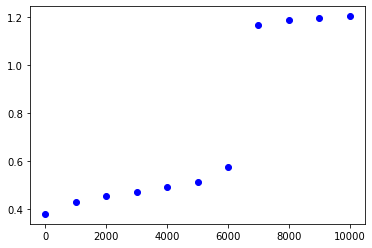

In [92]:
"""
CODE BLOCK 10

Acquire data, add titrant then plot data from all titration steps. 
Do not rerun Code Block 9 before the end of the titration
This Code Block will be run repeatedly throughout the titration
"""
# parameters for voltage measurements
samp_rate = 50
samp_num = 100

# define step size or the amount of titrant dispensed in each step
num_steps = 1000
if (num_steps + history_steps[-1] > 11000):
    raise ValueError("Total Steps will exceed 11000. Decrease num_steps")
    
    
    
# take voltage measurement
curr_meas = get_potential_measurement(samp_rate, samp_num)
all_potential_measurements.append(curr_meas)

# get a cumulative total of steps added
history_steps.append(num_steps)
history_steps[-1] += history_steps[-2] 

# tell syringe pump to add titrant
add_titrant(num_steps)

# append data to arrays
all_mean = [np.mean(meas_i) for meas_i in all_potential_measurements]
all_std = [np.std(meas_i) for meas_i in all_potential_measurements]

print(history_steps)
print(all_mean)

# plot results so far and save it. Make sure to change the image name for the second titration 
plt.errorbar(history_steps[:-1], all_mean, yerr=all_std,  fmt='bo')
plt.savefig('rough titration.png', dpi = 300, bbox_inches='tight')

# print data
titration_data = pd.DataFrame({'step': history_steps[:-1] , 'mean potential': all_mean, 'std dev': all_std})
print(titration_data)

In [93]:
"""
CODE BLOCK 11

Save plot and titration data. Make sure to rename the plot and txt file in your second titration 

"""

# Save titration data as txt. Make sure to change the name for each titration
titration_data.to_csv('rough titration.txt', index = False)



# Section 5: Pump Calibration

In this section you will gravimetrically calibrate the amount of titrant dispensed. 

In [100]:
"""
CODE BLOCK 12

"""

# fill syringe
initialize_and_fill()


filling syringe


In [101]:
"""
CODE BLOCK 13
"""

# add 6000 steps of the Ce(IV) titrant to an empty vial and weigh it
add_titrant(6000)

adding titrant


In [142]:
# return undispensed solution 
return_and_close()

emptying syringe
